# Init

In [ ]:
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

from prettytable import PrettyTable

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

rng = np.random.RandomState(1234567890)

In [ ]:
data_p = Path("/content/drive/MyDrive/Colab Notebooks/2023/S03E26_PlayCirrhosis/Data")
train, test = pd.read_csv(data_p / "train.csv.gz"), pd.read_csv(data_p / "test.csv.gz")
train = train.rename(columns=lambda x: x.lower().strip())
test = test.rename(columns=lambda x: x.lower().strip())

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   n_days         7905 non-null   int64  
 2   drug           7905 non-null   object 
 3   age            7905 non-null   int64  
 4   sex            7905 non-null   object 
 5   ascites        7905 non-null   object 
 6   hepatomegaly   7905 non-null   object 
 7   spiders        7905 non-null   object 
 8   edema          7905 non-null   object 
 9   bilirubin      7905 non-null   float64
 10  cholesterol    7905 non-null   float64
 11  albumin        7905 non-null   float64
 12  copper         7905 non-null   float64
 13  alk_phos       7905 non-null   float64
 14  sgot           7905 non-null   float64
 15  tryglicerides  7905 non-null   float64
 16  platelets      7905 non-null   float64
 17  prothrombin    7905 non-null   float64
 18  stage   

In [ ]:
train["status"].value_counts()

C     4965
D     2665
CL     275
Name: status, dtype: int64

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(columns=["id"]), train["status"], test_size=0.2, stratify=train["status"], random_state=rng)
X_train.shape, X_val.shape

((6324, 19), (1581, 19))

# EDA

In [ ]:
X_train["stage"] = X_train["stage"].astype(object)

numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(include=object).columns.drop("status").tolist()

le = LabelEncoder()
X_train["status"] = le.fit_transform(X_train["status"])

In [ ]:
X_train[numeric_cols].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).round(2)

,n_days,age,bilirubin,cholesterol,albumin,copper,alk_phos,sgot,tryglicerides,platelets,prothrombin
count,6324.00,6324.00,6324.00,6324.00,6324.00,6324.00,6324.00,6324.00,6324.00,6324.00,6324.00
mean,2029.16,18365.47,2.61,349.68,3.54,84.21,1831.97,114.62,115.55,264.82,10.63
std,1094.82,3690.29,3.85,194.76,0.35,76.23,1919.76,48.99,53.75,86.80,0.78
min,41.00,9598.00,0.30,120.00,1.96,4.00,289.00,26.35,33.00,62.00,9.00
1%,110.00,11058.00,0.40,151.00,2.43,10.00,414.00,43.40,49.00,81.00,9.50
10%,762.00,13329.00,0.60,219.00,3.08,24.00,661.00,58.00,63.00,151.00,9.80
25%,1230.00,15548.00,0.70,248.00,3.35,39.00,836.00,75.95,84.00,212.00,10.00
50%,1832.00,18713.00,1.10,298.00,3.58,63.00,1181.00,108.50,104.00,264.50,10.60
75%,2689.00,20684.00,3.00,390.00,3.77,102.00,1857.00,137.95,139.00,316.00,11.00
90%,3672.00,22960.00,6.47,514.00,3.95,172.00,3472.00,175.15,175.00,373.00,11.60


In [ ]:
X_train[cat_cols].describe()

,drug,sex,ascites,hepatomegaly,spiders,edema,stage
count,6324,6324,6324,6324,6324,6324,6324.0
unique,2,2,2,2,2,3,4.0
top,Placebo,F,N,Y,N,N,3.0
freq,3209,5863,6023,3244,4786,5732,2533.0


## Continuous

Long tailed: [bilirubin, cholesterol, copper, alk_phos, sgot, triglyceride]

Correlated with "status": [bilirubin, copper, prothrombin]

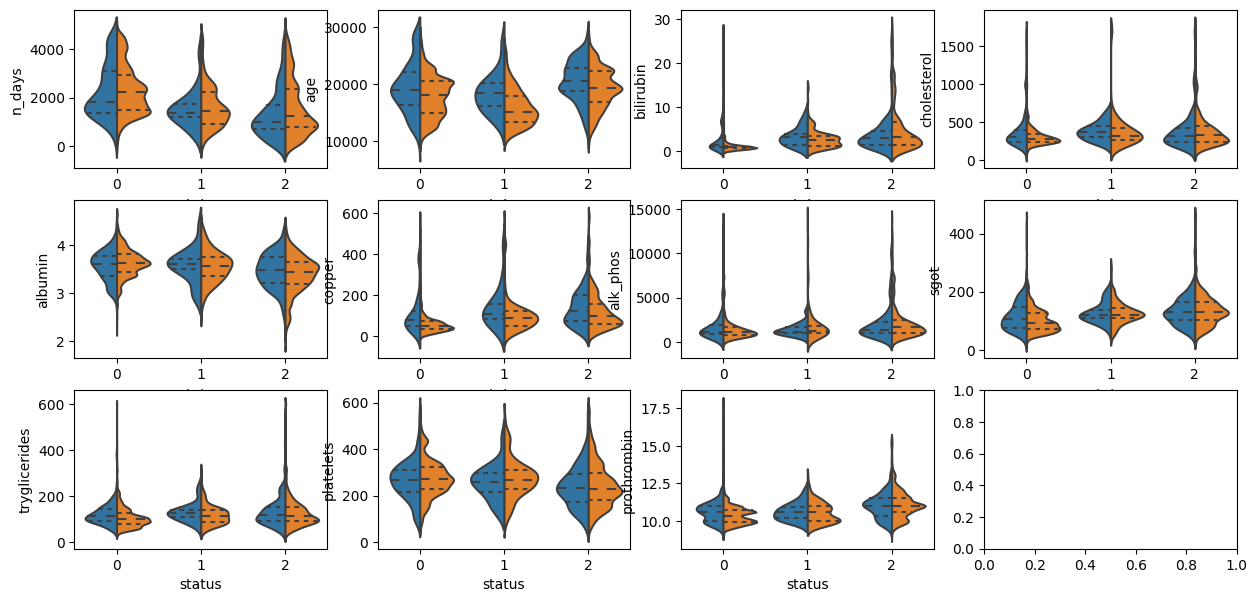

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=[15, 7])

# 0 - C, 1 - CL, 2 - D
# Blue - Male, Orange - Female
for i, c in enumerate(numeric_cols):
    g = sns.violinplot(data=X_train, x="status", y=c, hue="sex", fill=False, split=True, inner="quart", ax=ax[i // 4][i % 4])
    g.legend_.remove()

<Axes: >

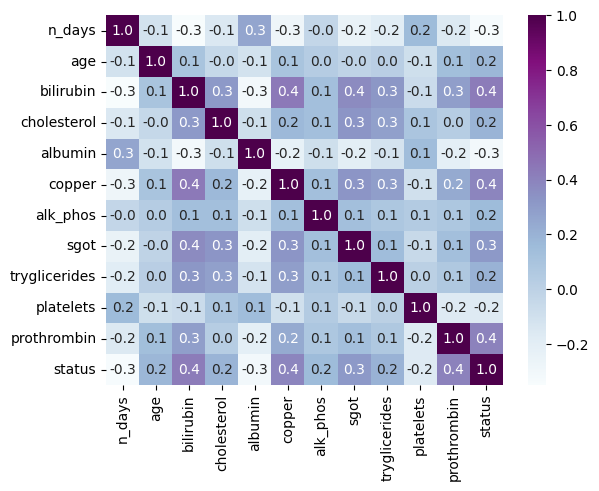

In [ ]:
sns.heatmap(X_train[numeric_cols + ["status"]].corr().round(2), cmap="BuPu", annot=True, fmt=".1f")

## Discrete

 - Stage 4 has higher probability of status == D


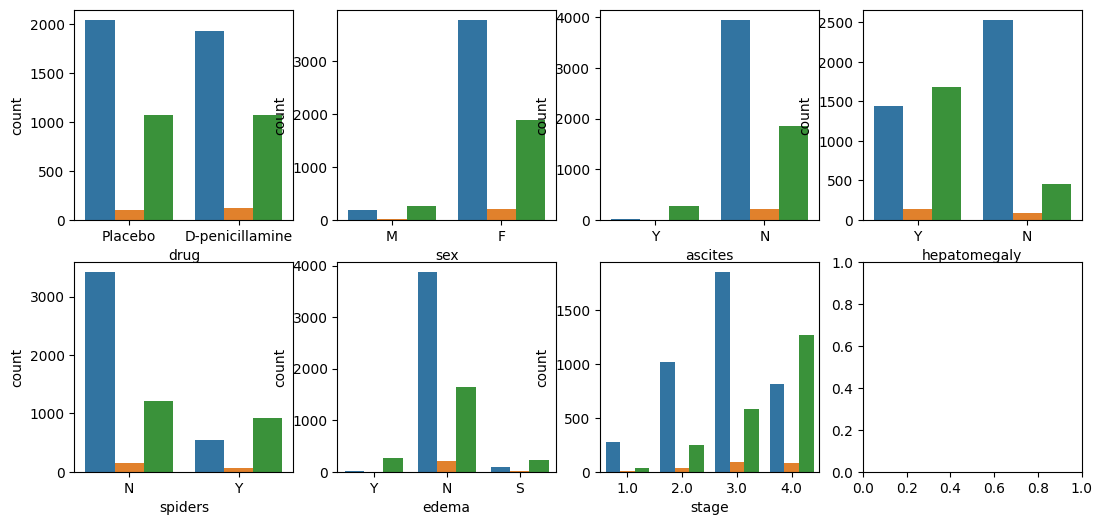

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=[13, 6])

# Blue - C, Orange - CL, Green - D
for i, c in enumerate(cat_cols):
    g = sns.countplot(data=X_train, x=c, hue="status", ax=ax[i // 4][i % 4])
    g.legend_.remove()

## Statistical tests

 - Very suspicious ANOVA and Kruskal values. ANOVA may not work as data may not be normally distributed.

In [ ]:
f_test, p_val = f_classif(X_train[numeric_cols], X_train["status"])
anova_tab = PrettyTable(field_names=["Variable", "F-score", "P-value"], sortby="F-score", reversesort=True)
anova_tab.add_rows(zip(numeric_cols, np.round(f_test, 2), np.round(p_val, 4)))

print(anova_tab)

+---------------+---------+---------+
|    Variable   | F-score | P-value |
+---------------+---------+---------+
|   bilirubin   |  721.17 |   0.0   |
|  prothrombin  |  603.87 |   0.0   |
|     copper    |  552.09 |   0.0   |
|     n_days    |  412.6  |   0.0   |
|      sgot     |  341.54 |   0.0   |
|    albumin    |  333.56 |   0.0   |
|      age      |  155.65 |   0.0   |
| tryglicerides |  125.79 |   0.0   |
|  cholesterol  |  114.72 |   0.0   |
|   platelets   |  101.77 |   0.0   |
|    alk_phos   |  84.44  |   0.0   |
+---------------+---------+---------+


In [ ]:
kruskal_tab = PrettyTable(field_names=["Variable", "H-score", "P-value"], sortby="H-score", reversesort=True)

for c in numeric_cols:
    st = scipy.stats.kruskal(X_train[c], X_train["status"], nan_policy="raise")
    kruskal_tab.add_row([c, round(st.statistic, 2), round(st.pvalue, 2)])

print(kruskal_tab)

+---------------+---------+---------+
|    Variable   | H-score | P-value |
+---------------+---------+---------+
|  prothrombin  | 9843.71 |   0.0   |
|     copper    | 9837.45 |   0.0   |
| tryglicerides | 9837.43 |   0.0   |
|      sgot     | 9837.36 |   0.0   |
|   platelets   | 9837.26 |   0.0   |
|  cholesterol  |  9837.2 |   0.0   |
|     n_days    | 9837.12 |   0.0   |
|    alk_phos   | 9837.12 |   0.0   |
|      age      | 9837.11 |   0.0   |
|    albumin    | 9829.31 |   0.0   |
|   bilirubin   | 2588.02 |   0.0   |
+---------------+---------+---------+


In [ ]:
ct_1 = ColumnTransformer([
    ("oe", OrdinalEncoder(), cat_cols),
    ("", "passthrough", numeric_cols + ["status"])
])
ct_1.set_output(transform="pandas")
X_train = ct_1.fit_transform(X_train)
X_train = X_train.rename(columns=lambda x: x.strip("_"))

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6324 entries, 4932 to 2899
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   oe__drug          6324 non-null   float64
 1   oe__sex           6324 non-null   float64
 2   oe__ascites       6324 non-null   float64
 3   oe__hepatomegaly  6324 non-null   float64
 4   oe__spiders       6324 non-null   float64
 5   oe__edema         6324 non-null   float64
 6   oe__stage         6324 non-null   float64
 7   n_days            6324 non-null   int64  
 8   age               6324 non-null   int64  
 9   bilirubin         6324 non-null   float64
 10  cholesterol       6324 non-null   float64
 11  albumin           6324 non-null   float64
 12  copper            6324 non-null   float64
 13  alk_phos          6324 non-null   float64
 14  sgot              6324 non-null   float64
 15  tryglicerides     6324 non-null   float64
 16  platelets         6324 non-null   float

In [ ]:
mi = mutual_info_classif(X_train.drop(columns=["status"]), X_train["status"])

mitab = PrettyTable(field_names=["Variable", "MI"], sortby="MI", reversesort=True)
mitab.add_rows(zip(X_train.drop(columns=["status"]).columns.tolist(), np.round(mi, 4)))

print(mitab)

+------------------+--------+
|     Variable     |   MI   |
+------------------+--------+
|      n_days      | 0.1879 |
|    bilirubin     | 0.184  |
|      copper      | 0.1662 |
|   cholesterol    | 0.143  |
|     alk_phos     | 0.143  |
|       sgot       | 0.1377 |
|    platelets     | 0.1348 |
|       age        | 0.1292 |
|   prothrombin    | 0.1156 |
|  tryglicerides   |  0.09  |
|     albumin      | 0.0863 |
| oe__hepatomegaly | 0.0846 |
|    oe__stage     | 0.0767 |
|   oe__spiders    | 0.0577 |
|    oe__edema     | 0.0556 |
|   oe__ascites    | 0.041  |
|     oe__sex      | 0.0007 |
|     oe__drug     |  0.0   |
+------------------+--------+
